In [1]:
import os
import urllib
import logging

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import Dataset, Subset, DataLoader, ConcatDataset
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import resnet34

from PIL import Image
from copy import deepcopy

import numpy as np

from sklearn.metrics import confusion_matrix

# LWF model

In [2]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.backends import cudnn

import numpy as np
from copy import deepcopy

class LWF():
    def __init__(self, device, net, old_net, criterion, optimizer, scheduler,
                 train_dataloader, val_dataloader, test_dataloader, num_classes=10):

        self.device = device

        self.net = net
        self.best_net = self.net
        self.old_net = old_net  # None for first ten classes

        # BCE formulation
        # Let x = logits, z = labels. The logistic loss is:
        # z * -log(sigmoid(x)) + (1 - z) * -log(1 - sigmoid(x))
        self.criterion = BCEWithLogitsLoss()
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader

        # can be incremented ouitside methods in the main, or inside methods
        self.num_classes = num_classes
        self.order = np.arange(100)

        self.sigmoid = nn.Sigmoid()

    def warm_up():
        pass

    def increment_classes(self, n=10):
        """Add n classes in the final fully connected layer."""

        in_features = self.net.fc.in_features  # size of each input sample
        out_features = self.net.fc.out_features  # size of each output sample
        weight = self.net.fc.weight.data

        self.net.fc = nn.Linear(in_features, out_features+n)
        self.net.fc.weight.data[:out_features] = weight

    def to_onehot(self, targets):
        """Convert targets to one-hot encoding (for BCE loss).
        Args:
            targets: dataloader.dataset.targets of the new task images
        """

        one_hot_targets = torch.eye(self.num_classes)[targets]

        return one_hot_targets.to(self.device)

    def do_first_batch(self, batch, labels):
        batch = batch.to(self.device)
        labels = labels.to(self.device)  # new classes labels

        # Zero-ing the gradients
        self.optimizer.zero_grad()

        # One hot encoding of new task labels
        one_hot_labels = self.to_onehot(labels)  # Size = [128, 10]

        # New net forward pass
        outputs = self.net(batch)

        # BCE Loss with sigmoids over outputs
        loss = self.criterion(outputs, one_hot_labels)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Accuracy over NEW IMAGES, not over all images
        running_corrects = \
            torch.sum(preds == labels.data).data.item()

        # Backward pass: computes gradients
        loss.backward()

        self.optimizer.step()

        return loss, running_corrects

    def do_batch(self, batch, labels):
        batch = batch.to(self.device)
        labels = labels.to(self.device)  # new classes labels

        # Zero-ing the gradients
        self.optimizer.zero_grad()

        # One hot encoding of new task labels
        # Size = [128, n_classes] will be sliced as [:, :self.num_classes-10]
        one_hot_labels = self.to_onehot(labels)
        new_classes = (
            self.order[range(self.num_classes-10, self.num_classes)]).astype(np.int32)
        one_hot_labels = torch.stack(
            [one_hot_labels[:, i] for i in new_classes], axis=1)

        # Old net forward pass
        old_outputs = self.sigmoid(self.old_net(batch))  # Size = [128, 100]
        old_classes = (self.order[range(self.num_classes-10)]).astype(np.int32)
        old_outputs = torch.stack([old_outputs[:, i]
                                   for i in old_classes], axis=1)

        # Combine new and old class targets
        targets = torch.cat((old_outputs, one_hot_labels), 1)

        # New net forward pass
        # Size = [128, 100] comparable with the define targets
        outputs = self.net(batch)
        out_classes = (self.order[range(self.num_classes)]).astype(np.int32)
        outputs = torch.stack([outputs[:, i] for i in out_classes], axis=1)

        # BCE Loss with sigmoids over outputs (over targets must be done manually)
        loss = self.criterion(outputs, targets)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # Accuracy over NEW IMAGES, not over all images
        running_corrects = \
            torch.sum(preds == labels.data).data.item()

        # Backward pass: computes gradients
        loss.backward()

        self.optimizer.step()

        return loss, running_corrects

    def do_epoch(self, current_epoch):
        self.net.train()

        running_train_loss = 0
        running_corrects = 0
        total = 0
        batch_idx = 0

        print(f"Epoch: {current_epoch}, LR: {self.scheduler.get_last_lr()}")

        for images, labels in self.train_dataloader:

            if self.num_classes == 10:
                loss, corrects = self.do_first_batch(images, labels)
            else:
                loss, corrects = self.do_batch(images, labels)

            running_train_loss += loss.item()
            running_corrects += corrects
            total += labels.size(0)
            batch_idx += 1

        self.scheduler.step()

        # Calculate average scores
        train_loss = running_train_loss / batch_idx  # Average over all batches
        train_accuracy = running_corrects / \
            float(total)  # Average over all samples

        print(f"Train loss: {train_loss}, Train accuracy: {train_accuracy}")

        return train_loss, train_accuracy

    def train(self, num_epochs):
        """Train the network for a specified number of epochs, and save
        the best performing model on the validation set.
        Args:
            num_epochs (int): number of epochs for training the network.
        Returns:
            train_loss: loss computed on the last epoch
            train_accuracy: accuracy computed on the last epoch
            val_loss: average loss on the validation set of the last epoch
            val_accuracy: accuracy on the validation set of the last epoch
        """

        # @todo: is the return behaviour intended? (scores of the last epoch)

        self.net = self.net.to(self.device)
        if self.old_net != None:
            self.old_net = self.old_net.to(self.device)
            self.old_net.train(False)

        cudnn.benchmark  # Calling this optimizes runtime

        self.best_loss = float("inf")
        self.best_epoch = 0

        for epoch in range(num_epochs):
                # Run an epoch (start counting form 1)
            train_loss, train_accuracy = self.do_epoch(epoch+1)

            # Validate after each epoch
            val_loss, val_accuracy = self.validate()

            # Best validation model
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_net = deepcopy(self.net)
                self.best_epoch = epoch
                print("Best model updated")

            print("")

        return train_loss, train_accuracy, val_loss, val_accuracy

    def validate(self):
        """Validate the model.
        Returns:
            val_loss: average loss function computed on the network outputs
                of the validation set (val_dataloader).
            val_accuracy: accuracy computed on the validation set.
        """

        self.net.train(False)

        running_val_loss = 0
        running_corrects = 0
        total = 0
        batch_idx = 0

        for batch, labels in self.val_dataloader:
            batch = batch.to(self.device)
            labels = labels.to(self.device)
            total += labels.size(0)

            # One hot encoding of new task labels
            # Size = [128, 100] will be sliced as [:, :self.num_classes-10]
            one_hot_labels = self.to_onehot(labels)
            new_classes = (
                self.order[range(self.num_classes-10, self.num_classes)]).astype(np.int32)
            one_hot_labels = torch.stack(
                [one_hot_labels[:, i] for i in new_classes], axis=1)

            if self.num_classes > 10:
                # Old net forward pass
                old_outputs = self.sigmoid(
                    self.old_net(batch))  # Size = [128, 100]
                old_classes = (
                    self.order[range(self.num_classes-10)]).astype(np.int32)
                old_outputs = torch.stack(
                    [old_outputs[:, i] for i in old_classes], axis=1)

                # Combine new and old class targets
                targets = torch.cat((old_outputs, one_hot_labels), 1)

            else:
                targets = one_hot_labels

            # New net forward pass
            # Size = [128, 100] comparable with the define targets
            outputs = self.net(batch)
            out_classes = (
                self.order[range(self.num_classes)]).astype(np.int32)
            outputs = torch.stack([outputs[:, i] for i in out_classes], axis=1)

            # BCE Loss with sigmoids over outputs (over targets must be done manually)
            loss = self.criterion(outputs, targets)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)

            # Update the number of correctly classified validation samples
            running_corrects += torch.sum(preds == labels.data).data.item()
            running_val_loss += loss.item()

            batch_idx += 1

        # Calcuate scores
        val_loss = running_val_loss / batch_idx
        val_accuracy = running_corrects / float(total)

        print(
            f"Validation loss: {val_loss}, Validation accuracy: {val_accuracy}")

        return val_loss, val_accuracy

    def test(self):
        """Test the model.
        Returns:
            accuracy (float): accuracy of the model on the test set
        """

        self.best_net.train(False)  # Set Network to evaluation mode

        running_corrects = 0
        total = 0

        all_preds = torch.tensor([])  # to store all predictions
        all_preds = all_preds.type(torch.LongTensor)
        all_targets = torch.tensor([])
        all_targets = all_targets.type(torch.LongTensor)

        for images, labels in self.test_dataloader:
            images = images.to(self.device)
            labels = labels.to(self.device)
            total += labels.size(0)

            # Forward Pass
            outputs = self.best_net(images)

            # Get predictions
            _, preds = torch.max(outputs.data, 1)

            # Update Corrects
            running_corrects += torch.sum(preds == labels.data).data.item()

            all_targets = torch.cat(
                (all_targets.to(self.device), labels.to(self.device)), dim=0
            )

            # Append batch predictions
            all_preds = torch.cat(
                (all_preds.to(self.device), preds.to(self.device)), dim=0
            )

        # Calculate accuracy
        accuracy = running_corrects / float(total)

        print(f"Test accuracy: {accuracy}")

        return accuracy, all_targets, all_preds

# ResNet

In [3]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.nn import functional as F
import math
import torch.utils.model_zoo as model_zoo

"""
Credits to @hshustc
Taken from https://github.com/hshustc/CVPR19_Incremental_Learning/tree/master/cifar100-class-incremental
"""


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class BasicBlockNoReLU(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlockNoReLU, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        # out = self.relu(out)

        return out

class CosineLayer(nn.Module):
    def __init__(self, in_features, out_features, eta=True):
        super(CosineLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if eta:
            self.eta = Parameter(torch.Tensor(1))
        else:
            self.register_parameter('eta', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

        if self.eta is not None:
            self.eta.data.fill_(1)

    def forward(self, input):
        out = F.linear(F.normalize(input, p=2, dim=1), F.normalize(self.weight, p=2, dim=1))

        if self.eta is not None:
            out = self.eta * out

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x
    
    def features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

class ResNetCosine(nn.Module):

    def __init__(self, block, blocknorelu, layers, num_classes=10):
        self.inplanes = 16
        super(ResNetCosine, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        # self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.layer3norelu = self._make_layer(blocknorelu, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        # self.fc = nn.Linear(64 * block.expansion, num_classes)
        self.fc = CosineLayer(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, features=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3norelu(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        if features == False:
            x = self.fc(x)

        return x

def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32cosine(pretrained=False, **kwargs):
    n = 5
    model = ResNetCosine(BasicBlock, BasicBlockNoReLU, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model

# Cifar100

In [4]:
import numpy as np
import torch
from torchvision import transforms
from torchvision import datasets
from PIL import Image

class Cifar100(torch.utils.data.Dataset):
    def __init__(self, root, train, download, random_state, transform=None):
        self.train = train
        self.transform = transform
        self.is_transform_enabled = True

        self.dataset = datasets.cifar.CIFAR100(
            root=root,
            train=train,
            download=download,
            transform=None)

        self.targets = np.array(self.dataset.targets)

        # Use class_batches(k:[batch labels]) to build k-th split dataset
        self.batch_splits = self.class_batches(random_state)

    def set_classes_batch(self, batch_idx):
        self.batch_idx =  batch_idx

        # Boolean mask returning only indexes where (real) targets match an element of batch_idx 
        mask = np.isin(self.targets, self.batch_idx) 

        # Batch indices of interest
        idxes = np.where(mask)[0]

        # fake_idx = index used in __getitem__ to retrieve record of interest
        # real_idx = index used in __getitem__ to return element form self.dataset
        self.batches_mapping = {
            fake_idx: real_idx
            for fake_idx, real_idx in enumerate(idxes)
        }

        self.idxes = np.array(idxes)

    def class_batches(self, random_state):
        batch_splits = dict.fromkeys(np.arange(0, 10)) # {0:None, 1:None, ... , 9:None}

        rs = np.random.RandomState(random_state)
        random_labels =list(range(0,  100)) # [0-99] labels
        rs.shuffle(random_labels) # randomly shuffle the labels

        for i in range(10):
            # Take 10-sized label batches and define the class splits
            batch_splits[i] = random_labels[i*10 : (i+1)*10] # {0:[1-st split classes], 1:[...], ... , 99:[...]}
        
        # Label mapping
        self.label_map = {k:v for v,k in enumerate(random_labels)}

        return batch_splits

    def set_exemplars(self, idxes):
        self.batches_mapping.update({
            fake_idx: real_idx
            for fake_idx, real_idx in zip(range(len(self.batches_mapping), len(idxes)), idxes)
        })

    def train_val_split(self, val_size, random_state):
        len_dataset = len(self.batches_mapping)
        indices = list(range(len_dataset))
        split = int(np.floor(val_size * len_dataset))
        
        rs = np.random.RandomState(random_state) # Seed the generator
        rs.shuffle(indices) # Shuffle indices to get balanced distribution in training and validation set

        train_indices, val_indices = indices[split:], indices[:split]

        return train_indices, val_indices

    def get_true_index(self, fake_idx):
        return self.batches_mapping[fake_idx]

    def enable_transform(self):
        self.is_transform_enabled = True

    def disable_transform(self):
        self.is_transform_enabled = False

    def transform_status(self):
        return self.is_transform_enabled

    def __len__(self):
        return len(self.batches_mapping)

    def __getitem__(self, idx):
        real_idx = self.batches_mapping[idx]

        image = self.dataset.data[real_idx]
        label = self.dataset.targets[real_idx]

        image = Image.fromarray(image) # Return a PIL image

        # Applies preprocessing when accessing the image if transformations are currently enabled
        if (self.transform is not None) and (self.is_transform_enabled is True):
            image = self.transform(image)

        mapped_label = self.label_map[label]

        return image, mapped_label

# Arguments

In [5]:

# Directories
DATA_DIR = 'data'       # Directory where the dataset will be downloaded

# Settings
DEVICE = 'cuda'

# Dataset
RANDOM_STATES = [658, 423, 422]      # For reproducibility of results                        
                                     # Note: different random states give very different
                                     # splits and therefore very different results.

NUM_CLASSES = 100       # Total number of classes

VAL_SIZE = 0.1          # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 64         # Batch size (iCaRL sets this to 128)
LR = 2                  # Initial learning rate
                       
MOMENTUM = 0.9          # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5     # Weight decay from iCaRL

NUM_RUNS = 3            # Number of runs of every method
                        # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70         # Total number of training epochs
MILESTONES = [49, 63]   # Step down policy from iCaRL (MultiStepLR)
                        # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2 

# LWF


In [6]:
train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

In [7]:
train_dataloaders = [[] for i in range(NUM_RUNS)]
val_dataloaders = [[] for i in range(NUM_RUNS)]
test_dataloaders = [[] for i in range(NUM_RUNS)]

for run_i in range(NUM_RUNS):
    test_subsets = []
    random_state = RANDOM_STATES[run_i]

    for split_i in range(10):
        # Download dataset only at first instantiation
        if run_i+split_i == 0:
            download = True
        else:
            download = False

        # Create CIFAR100 dataset
        train_dataset = Cifar100(DATA_DIR, train=True, download=download, random_state=random_state, transform=train_transform)
        test_dataset = Cifar100(DATA_DIR, train=False, download=False, random_state=random_state, transform=test_transform)

        # Subspace of CIFAR100 of 10 classes
        train_dataset.set_classes_batch(train_dataset.batch_splits[split_i])
        test_dataset.set_classes_batch([test_dataset.batch_splits[i] for i in range(0, split_i+1)])

        # Define train and validation indices
        train_indices, val_indices = train_dataset.train_val_split(VAL_SIZE, random_state)

        train_dataloaders[run_i].append(DataLoader(Subset(train_dataset, train_indices),
                                                   batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True))

        val_dataloaders[run_i].append(DataLoader(Subset(train_dataset, val_indices),
                                                 batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True))

        # Dataset with all seen class
        test_dataloaders[run_i].append(DataLoader(test_dataset,
                                                  batch_size=BATCH_SIZE, shuffle=True, num_workers=2))


Files already downloaded and verified


/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# PLOT

In [8]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import torch
import torchvision

DPI = 100

def image_grid(images, one_channel=False):
    """Show an image grid.

    Args:
        images (torch.Tensor): batch of images to show
        one_channel (bool): if True, show images in grayscale, otherwise
            show images in RGB (in this case, images tensor should contain
            three channels per image)
    """

    img_grid = torchvision.utils.make_grid(images)

    if one_channel:
        img_grid = img_grid.mean(dim=0)
    img_grid = img_grid / 2 + 0.5  # Unnormalize
    npimg = img_grid.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def compute_scores(logs, key):
    score = [[logs[run_i][i][key] for i in range(10)] for run_i in range(3)]
    score = np.array(score)
    return np.array([score.mean(0), score.std(0)]).transpose()

def train_val_scores(train_loss, train_accuracy, validation_loss, validation_accuracy, save_directory=None):
    """Plot loss and accuracy for training and validation

    The plot contains two axes:
        axes[0] is the loss plot
        axes[1] is the accuracy plot

    Args:
        train_loss, train_accuracy, validation_loss, validation_accuracy:
            mean and standard deviation with comparable x axis
        save_directory (path): if specified, save the plot as a file in this
            directory
    """

    fig, axes = plt.subplots(1, 2, figsize=[15, 5], dpi=DPI)

    x = np.arange(10, 101, 10)

    # Use errorbar to plot the standard deviation between different runs
    axes[0].errorbar(x, np.array(train_loss)[:, 0], np.array(train_loss)[:, 1],
                     color='#2E84D5', linestyle = '-', linewidth=2.5, marker = ".", label='Training')
    axes[0].errorbar(x, np.array(validation_loss)[:, 0], np.array(validation_loss)[:, 1],
                     color='#FF9232', linestyle = '-', linewidth=2.5, marker = ".", label='Validation')
    axes[0].set_title("Training and validation loss")
    axes[0].set_xlabel("Number of classes")
    axes[0].set_ylabel("Loss")

    axes[1].errorbar(x, np.array(train_accuracy)[:, 0], np.array(train_accuracy)[:, 1],
                     color='#2E84D5', linestyle = '-', linewidth=2.5, marker = ".", label='Training')
    axes[1].errorbar(x, np.array(validation_accuracy)[:, 0], np.array(validation_accuracy)[:, 1],
                     color='#FF9232', linestyle = '-', linewidth=2.5, marker = ".", label='Validation')
    axes[1].set_title("Training and validation accuracy")
    axes[1].set_xlabel("Number of classes")
    axes[1].set_ylabel("Accuracy")

    # Layout
    plt.tight_layout()

    axes[0].legend()
    axes[0].grid(True)

    axes[1].legend()
    axes[1].grid(True)

    # Save image if directory is specified
    if save_directory != None:
        fig.savefig(save_directory)

    plt.show()


def test_scores(test_accuracy, save_directory=None):
    """Plot accuracy for test
    
    Args:
        test_accuracy: mean and standard deviation of test accuracy
        save_directory (path): if specified, save the plot as a file in this
            directory
    """

    fig, ax = plt.subplots(figsize=[15, 5], dpi=DPI)

    x = np.arange(10, 101, 10)

    # Use errorbar to plot the standard deviation between different runs
    ax.errorbar(x, np.array(test_accuracy)[:, 0], np.array(test_accuracy)[:, 1],
                  color='#2E84D5', linestyle = '-', linewidth=2.5, marker = ".")
    ax.set_title("Test accuracy")
    ax.set_xlabel("Number of classes")
    ax.set_ylabel("Accuracy")

    # Layout
    plt.tight_layout()

    ax.grid(True)

    # Save image if directory is specified
    if save_directory != None:
        fig.savefig(save_directory)

    plt.show()

def heatmap_cm(targets, preds, annotated = None):
    """Confusion matrix heatmap"""

    cm = confusion_matrix(targets, preds)

    fig, ax = plt.subplots(figsize=(5, 5), dpi=DPI)
    ax = sns.heatmap(cm, square=True, cmap = 'Blues', annot=annotated)
    plt.show()

/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


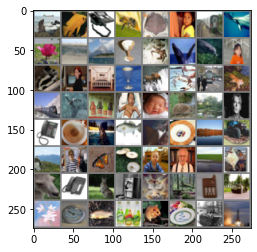

In [9]:
# Sanity check: visualize a batch of images
dataiter = iter(test_dataloaders[0][5])
images, labels = dataiter.next()

image_grid(images, one_channel=False)

In [10]:
# Arguments for Learning without Forgetting
BATCH_SIZE = 128
LR = 2

In [122]:
NUM_RUNS=3

In [123]:
logs = [[] for _ in range(NUM_RUNS)]

# Iterate over runs
for run_i in range(NUM_RUNS):
    net = resnet32()
    
    criterion = nn.BCEWithLogitsLoss()
    
    for split_i in range(2):
        print(f"## Split {split_i} of run {run_i} ##")

        # Redefine optimizer at each split (pass by reference issue)
        parameters_to_optimize = net.parameters()
        optimizer = optim.SGD(parameters_to_optimize, lr=LR,
                                momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                                    milestones=MILESTONES, gamma=GAMMA)

        num_classes = 10*(split_i+1)

        if num_classes == 10: # old network == None
            lwf = LWF(DEVICE, net, None, criterion, optimizer, scheduler,
                            train_dataloaders[run_i][split_i],
                            val_dataloaders[run_i][split_i],
                            test_dataloaders[run_i][split_i],
                            num_classes)
        else:
            lwf = LWF(DEVICE, net, old_net, criterion, optimizer, scheduler,
                            train_dataloaders[run_i][split_i],
                            val_dataloaders[run_i][split_i],
                            test_dataloaders[run_i][split_i],
                            num_classes)

        scores = lwf.train(NUM_EPOCHS)  # train the model

        logs[run_i].append({})

        # score[i] = dictionary with key:epoch, value: score
        logs[run_i][split_i]['train_loss'] = scores[0]
        logs[run_i][split_i]['train_accuracy'] = scores[1]
        logs[run_i][split_i]['val_loss'] = scores[2]
        logs[run_i][split_i]['val_accuracy'] = scores[3]

        # Test the model on classes seen until now
        test_accuracy, all_targets, all_preds = lwf.test()

        logs[run_i][split_i]['test_accuracy'] = test_accuracy
        logs[run_i][split_i]['conf_mat'] = confusion_matrix(all_targets.to('cpu'), all_preds.to('cpu'))

        old_net = deepcopy(lwf.net)

        lwf.increment_classes()

## Split 0 of run 0 ##
Epoch: 1, LR: [2]
Train loss: 0.36986718220370157, Train accuracy: 0.1234375
Validation loss: 0.3127413349492209, Validation accuracy: 0.17410714285714285
Best model updated

Epoch: 2, LR: [2]
Train loss: 0.3171685542379107, Train accuracy: 0.15022321428571428
Validation loss: 0.31117274505751474, Validation accuracy: 0.14955357142857142
Best model updated

Epoch: 3, LR: [2]
Train loss: 0.31521626710891726, Train accuracy: 0.16071428571428573
Validation loss: 0.30764985936028616, Validation accuracy: 0.17857142857142858
Best model updated

Epoch: 4, LR: [2]
Train loss: 0.3118102835757392, Train accuracy: 0.16785714285714284
Validation loss: 0.30697894947869436, Validation accuracy: 0.17410714285714285
Best model updated

Epoch: 5, LR: [2]
Train loss: 0.3018379930938993, Train accuracy: 0.2296875
Validation loss: 0.2950256083692823, Validation accuracy: 0.20982142857142858
Best model updated

Epoch: 6, LR: [2]
Train loss: 0.28504636883735657, Train accuracy: 0.293

/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss: 0.21487385290009633, Train accuracy: 0.06049107142857143
Validation loss: 0.18191049993038177, Validation accuracy: 0.15401785714285715
Best model updated

Epoch: 2, LR: [2]
Train loss: 0.15790995189121793, Train accuracy: 0.2506696428571429
Validation loss: 0.16222376695701055, Validation accuracy: 0.296875
Best model updated

Epoch: 3, LR: [2]
Train loss: 0.14105860899601663, Train accuracy: 0.3691964285714286
Validation loss: 0.16255250998905726, Validation accuracy: 0.3861607142857143

Epoch: 4, LR: [2]
Train loss: 0.1332025228866509, Train accuracy: 0.45022321428571427
Validation loss: 0.15055688789912633, Validation accuracy: 0.44642857142857145
Best model updated

Epoch: 5, LR: [2]
Train loss: 0.1269876570573875, Train accuracy: 0.5104910714285714
Validation loss: 0.1379184467451913, Validation accuracy: 0.4888392857142857
Best model updated

Epoch: 6, LR: [2]
Train loss: 0.12313435705644744, Train accuracy: 0.5377232142857142
Validation loss: 0.15019370189734868, Va

/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss: 0.3901967925684793, Train accuracy: 0.10825892857142858
Validation loss: 0.32956497158323017, Validation accuracy: 0.10044642857142858
Best model updated

Epoch: 2, LR: [2]
Train loss: 0.32575942405632563, Train accuracy: 0.10491071428571429
Validation loss: 0.32574349641799927, Validation accuracy: 0.10714285714285714
Best model updated

Epoch: 3, LR: [2]
Train loss: 0.3257062315940857, Train accuracy: 0.11049107142857142
Validation loss: 0.3257921636104584, Validation accuracy: 0.09151785714285714

Epoch: 4, LR: [2]
Train loss: 0.32497628373759135, Train accuracy: 0.10379464285714286
Validation loss: 0.3244253695011139, Validation accuracy: 0.109375
Best model updated

Epoch: 5, LR: [2]
Train loss: 0.3243898506675448, Train accuracy: 0.10625
Validation loss: 0.3257412867886679, Validation accuracy: 0.11160714285714286

Epoch: 6, LR: [2]
Train loss: 0.32346915134361814, Train accuracy: 0.12142857142857143
Validation loss: 0.32492412413869587, Validation accuracy: 0.09375



/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss: 0.22690118742840631, Train accuracy: 0.1314732142857143
Validation loss: 0.19775644370487758, Validation accuracy: 0.27901785714285715
Best model updated

Epoch: 2, LR: [2]
Train loss: 0.19210189133882521, Train accuracy: 0.3104910714285714
Validation loss: 0.19701626471110753, Validation accuracy: 0.36160714285714285
Best model updated

Epoch: 3, LR: [2]
Train loss: 0.18555547360863003, Train accuracy: 0.40133928571428573
Validation loss: 0.1834003052541188, Validation accuracy: 0.4799107142857143
Best model updated

Epoch: 4, LR: [2]
Train loss: 0.17926013129098076, Train accuracy: 0.4533482142857143
Validation loss: 0.185335995895522, Validation accuracy: 0.45535714285714285

Epoch: 5, LR: [2]
Train loss: 0.17277220338582994, Train accuracy: 0.5185267857142857
Validation loss: 0.17854492579187667, Validation accuracy: 0.5267857142857143
Best model updated

Epoch: 6, LR: [2]
Train loss: 0.1691515679870333, Train accuracy: 0.5444196428571428
Validation loss: 0.173865290624

/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss: 0.3950472810438701, Train accuracy: 0.10580357142857143
Validation loss: 0.3277201907975333, Validation accuracy: 0.10044642857142858
Best model updated

Epoch: 2, LR: [2]
Train loss: 0.32628237690244405, Train accuracy: 0.10044642857142858
Validation loss: 0.32681454505239216, Validation accuracy: 0.06919642857142858
Best model updated

Epoch: 3, LR: [2]
Train loss: 0.324142935020583, Train accuracy: 0.1328125
Validation loss: 0.32271979110581533, Validation accuracy: 0.16741071428571427
Best model updated

Epoch: 4, LR: [2]
Train loss: 0.3036495081015996, Train accuracy: 0.2140625
Validation loss: 0.2889723224299295, Validation accuracy: 0.26339285714285715
Best model updated

Epoch: 5, LR: [2]
Train loss: 0.28953101890427724, Train accuracy: 0.27098214285714284
Validation loss: 0.30492250834192547, Validation accuracy: 0.24330357142857142

Epoch: 6, LR: [2]
Train loss: 0.2840802741902215, Train accuracy: 0.29642857142857143
Validation loss: 0.2876525010381426, Validation

/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss: 0.21712114534207752, Train accuracy: 0.12767857142857142
Validation loss: 0.20111324318817683, Validation accuracy: 0.18973214285714285
Best model updated

Epoch: 2, LR: [2]
Train loss: 0.17875175050326755, Train accuracy: 0.3060267857142857
Validation loss: 0.1854589091879981, Validation accuracy: 0.375
Best model updated

Epoch: 3, LR: [2]
Train loss: 0.16866086231810706, Train accuracy: 0.421875
Validation loss: 0.16889203020504542, Validation accuracy: 0.45982142857142855
Best model updated

Epoch: 4, LR: [2]
Train loss: 0.16092928392546518, Train accuracy: 0.5008928571428571
Validation loss: 0.18276990737233842, Validation accuracy: 0.49776785714285715

Epoch: 5, LR: [2]
Train loss: 0.1585327610373497, Train accuracy: 0.5368303571428571
Validation loss: 0.1687186849968774, Validation accuracy: 0.5200892857142857
Best model updated

Epoch: 6, LR: [2]
Train loss: 0.15428125581571034, Train accuracy: 0.5680803571428571
Validation loss: 0.17267678678035736, Validation accu

In [124]:
test_accuracy

0.6315

In [95]:
import pandas as pd

In [125]:
logs_df=pd.DataFrame(logs[0])

In [105]:
logs_copy=deepcopy(logs)

In [126]:
logs_df["val_loss"]

0    0.072452
1    0.111091
Name: val_loss, dtype: float64

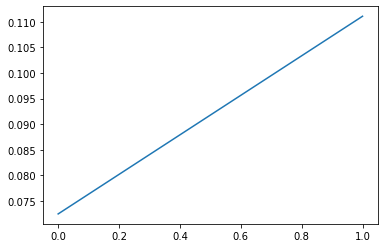

In [127]:
plt.plot(logs_df["val_loss"])

In [15]:
torch.save(lwf.old_net.state_dict(), 'old_model_weights_1run.pth')

In [16]:
torch.save(lwf.net.state_dict(), 'model_weights_1run.pth')

In [128]:
old_net_copy=deepcopy(lwf.old_net)
net_copy=deepcopy(lwf.net)

In [17]:
from sklearn.manifold import TSNE
from matplotlib import cm
from tqdm import tqdm

In [132]:
# test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 64), dtype=torch.float32)

old_net_copy.train(False)
old_net_copy = old_net_copy.cuda()
for i in range(3):
    for j in range(10):
        for x,y in tqdm(train_dataloaders[i][j]):
            x = x.cuda()
            # embeddings, logits = model(x)
            embeddings=old_net_copy.features(x)
            logits=old_net_copy.forward(x)
            preds = torch.argmax(logits, dim=1)
            test_predictions.extend(preds.detach().cpu().tolist())
            test_targets.extend(y.detach().cpu().tolist())
            test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
    # test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
# test_imgs = np.array(test_imgs)
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)

100%|██████████| 70/70 [00:02<00:00, 29.55it/s]


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 134400 samples in 0.006s...
[t-SNE] Computed neighbors for 134400 samples in 347.459s...
[t-SNE] Computed conditional probabilities for sample 1000 / 134400
[t-SNE] Computed conditional probabilities for sample 2000 / 134400
[t-SNE] Computed conditional probabilities for sample 3000 / 134400
[t-SNE] Computed conditional probabilities for sample 4000 / 134400
[t-SNE] Computed conditional probabilities for sample 5000 / 134400
[t-SNE] Computed conditional probabilities for sample 6000 / 134400
[t-SNE] Computed conditional probabilities for sample 7000 / 134400
[t-SNE] Computed conditional probabilities for sample 8000 / 134400
[t-SNE] Computed conditional probabilities for sample 9000 / 134400
[t-SNE] Computed conditional probabilities for sample 10000 / 134400
[t-SNE] Computed conditional probabilities for sample 11000 / 134400
[t-SNE] Computed conditional probabilities for sample 12000 / 134400
[t-SNE] Computed conditional proba

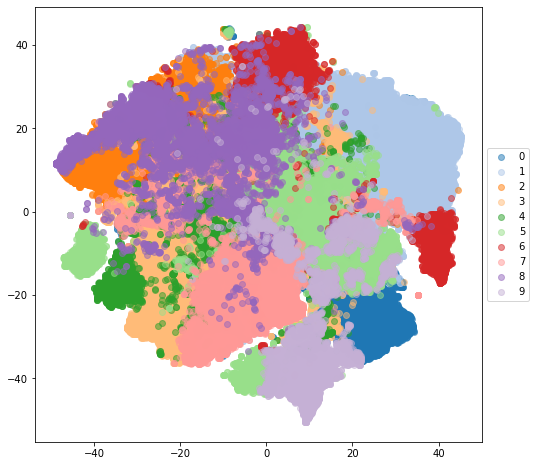

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 134400 samples in 0.006s...
[t-SNE] Computed neighbors for 134400 samples in 347.459s...
[t-SNE] Computed conditional probabilities for sample 1000 / 134400
[t-SNE] Computed conditional probabilities for sample 2000 / 134400
[t-SNE] Computed conditional probabilities for sample 3000 / 134400
[t-SNE] Computed conditional probabilities for sample 4000 / 134400
[t-SNE] Computed conditional probabilities for sample 5000 / 134400
[t-SNE] Computed conditional probabilities for sample 6000 / 134400
[t-SNE] Computed conditional probabilities for sample 7000 / 134400
[t-SNE] Computed conditional probabilities for sample 8000 / 134400
[t-SNE] Computed conditional probabilities for sample 9000 / 134400
[t-SNE] Computed conditional probabilities for sample 10000 / 134400
[t-SNE] Computed conditional probabilities for sample 11000 / 134400
[t-SNE] Computed conditional probabilities for sample 12000 / 134400
[t-SNE] Computed conditional proba

In [ ]:

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

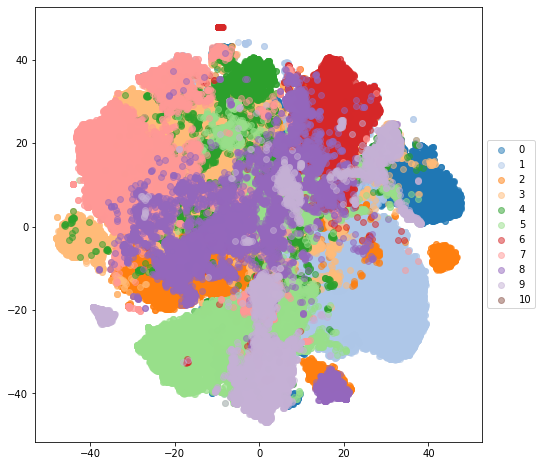

In [ ]:
fig

In [129]:
# test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 64), dtype=torch.float32)

net_copy.train(False)
net_copy = net_copy.cuda()
for i in range(3):
    for j in range(10):
        for x,y in tqdm(train_dataloaders[i][j]):
            x = x.cuda()
            # embeddings, logits = model(x)
            embeddings=net_copy.features(x)
            logits=net_copy.forward(x)
            preds = torch.argmax(logits, dim=1)
            test_predictions.extend(preds.detach().cpu().tolist())
            test_targets.extend(y.detach().cpu().tolist())
            test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
    # test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
# test_imgs = np.array(test_imgs)
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)

  0%|          | 0/70 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 70/70 [00:02<00:00, 29.56it/s]


In [144]:

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 134400 samples in 0.013s...
[t-SNE] Computed neighbors for 134400 samples in 348.187s...
[t-SNE] Computed conditional probabilities for sample 1000 / 134400
[t-SNE] Computed conditional probabilities for sample 2000 / 134400
[t-SNE] Computed conditional probabilities for sample 3000 / 134400
[t-SNE] Computed conditional probabilities for sample 4000 / 134400
[t-SNE] Computed conditional probabilities for sample 5000 / 134400
[t-SNE] Computed conditional probabilities for sample 6000 / 134400
[t-SNE] Computed conditional probabilities for sample 7000 / 134400
[t-SNE] Computed conditional probabilities for sample 8000 / 134400
[t-SNE] Computed conditional probabilities for sample 9000 / 134400
[t-SNE] Computed conditional probabilities for sample 10000 / 134400
[t-SNE] Computed conditional probabilities for sample 11000 / 134400
[t-SNE] Computed conditional probabilities for sample 12000 / 134400
[t-SNE] Computed conditional proba

In [146]:
num_categories%5

0

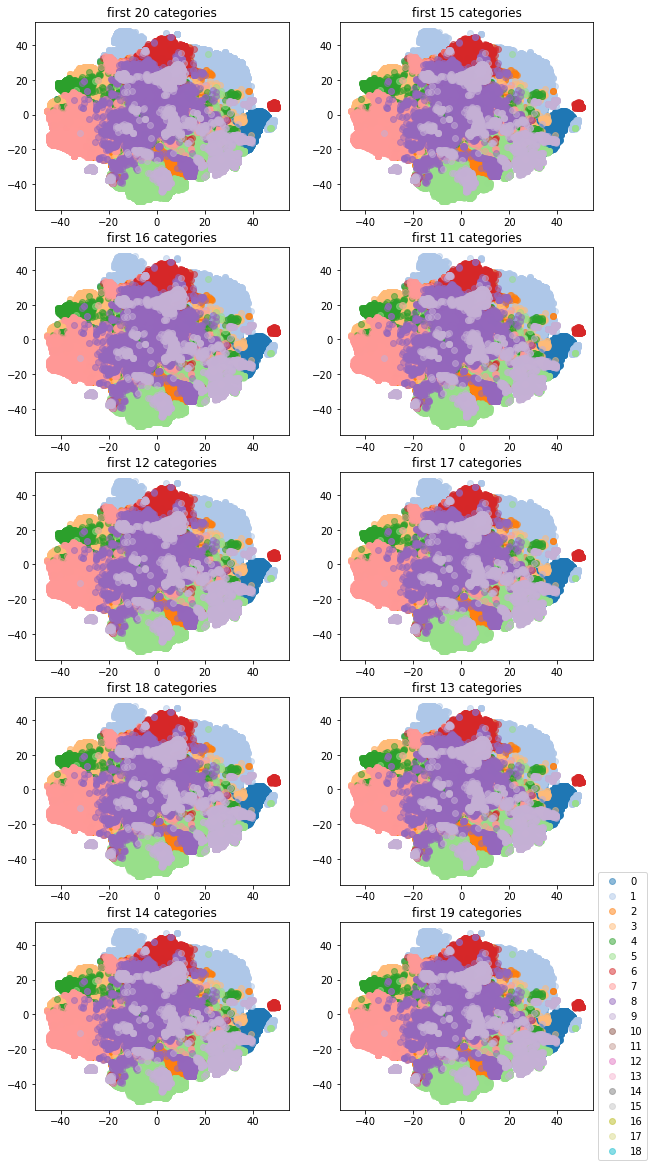

In [150]:
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(10,20))
for num_categories in range(10,21):
    for lab in range(num_categories):
        indices = test_predictions==lab
        ax[int(num_categories%5)][int(num_categories%2)].scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
        ax[int(num_categories%5)][int(num_categories%2)].set_title(f"first {num_categories} categories")
ax[4][1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [151]:
# test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 64), dtype=torch.float32)

net_copy.train(False)
net_copy = net_copy.cuda()
for i in range(3):
    for j in range(10):
        for x,y in tqdm(train_dataloaders[i][j]):
            x = x.cuda()
            # embeddings, logits = model(x)
            embeddings=net_copy.features(x)
            logits=net_copy.forward(x)
            preds = torch.argmax(logits, dim=1)
            test_predictions.extend(preds.detach().cpu().tolist())
            test_targets.extend(y.detach().cpu().tolist())
            test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
    # test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
# test_imgs = np.array(test_imgs)
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)

  0%|          | 0/70 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 70/70 [00:02<00:00, 29.84it/s]


In [160]:
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1,perplexity=50,learning_rate="auto")
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 134400 samples in 0.012s...
[t-SNE] Computed neighbors for 134400 samples in 307.084s...
[t-SNE] Computed conditional probabilities for sample 1000 / 134400
[t-SNE] Computed conditional probabilities for sample 2000 / 134400
[t-SNE] Computed conditional probabilities for sample 3000 / 134400
[t-SNE] Computed conditional probabilities for sample 4000 / 134400
[t-SNE] Computed conditional probabilities for sample 5000 / 134400
[t-SNE] Computed conditional probabilities for sample 6000 / 134400
[t-SNE] Computed conditional probabilities for sample 7000 / 134400
[t-SNE] Computed conditional probabilities for sample 8000 / 134400
[t-SNE] Computed conditional probabilities for sample 9000 / 134400
[t-SNE] Computed conditional probabilities for sample 10000 / 134400
[t-SNE] Computed conditional probabilities for sample 11000 / 134400
[t-SNE] Computed conditional probabilities for sample 12000 / 134400
[t-SNE] Computed conditional prob

In [175]:
fig.savefig("tsne.png",bbox_inches="tight")

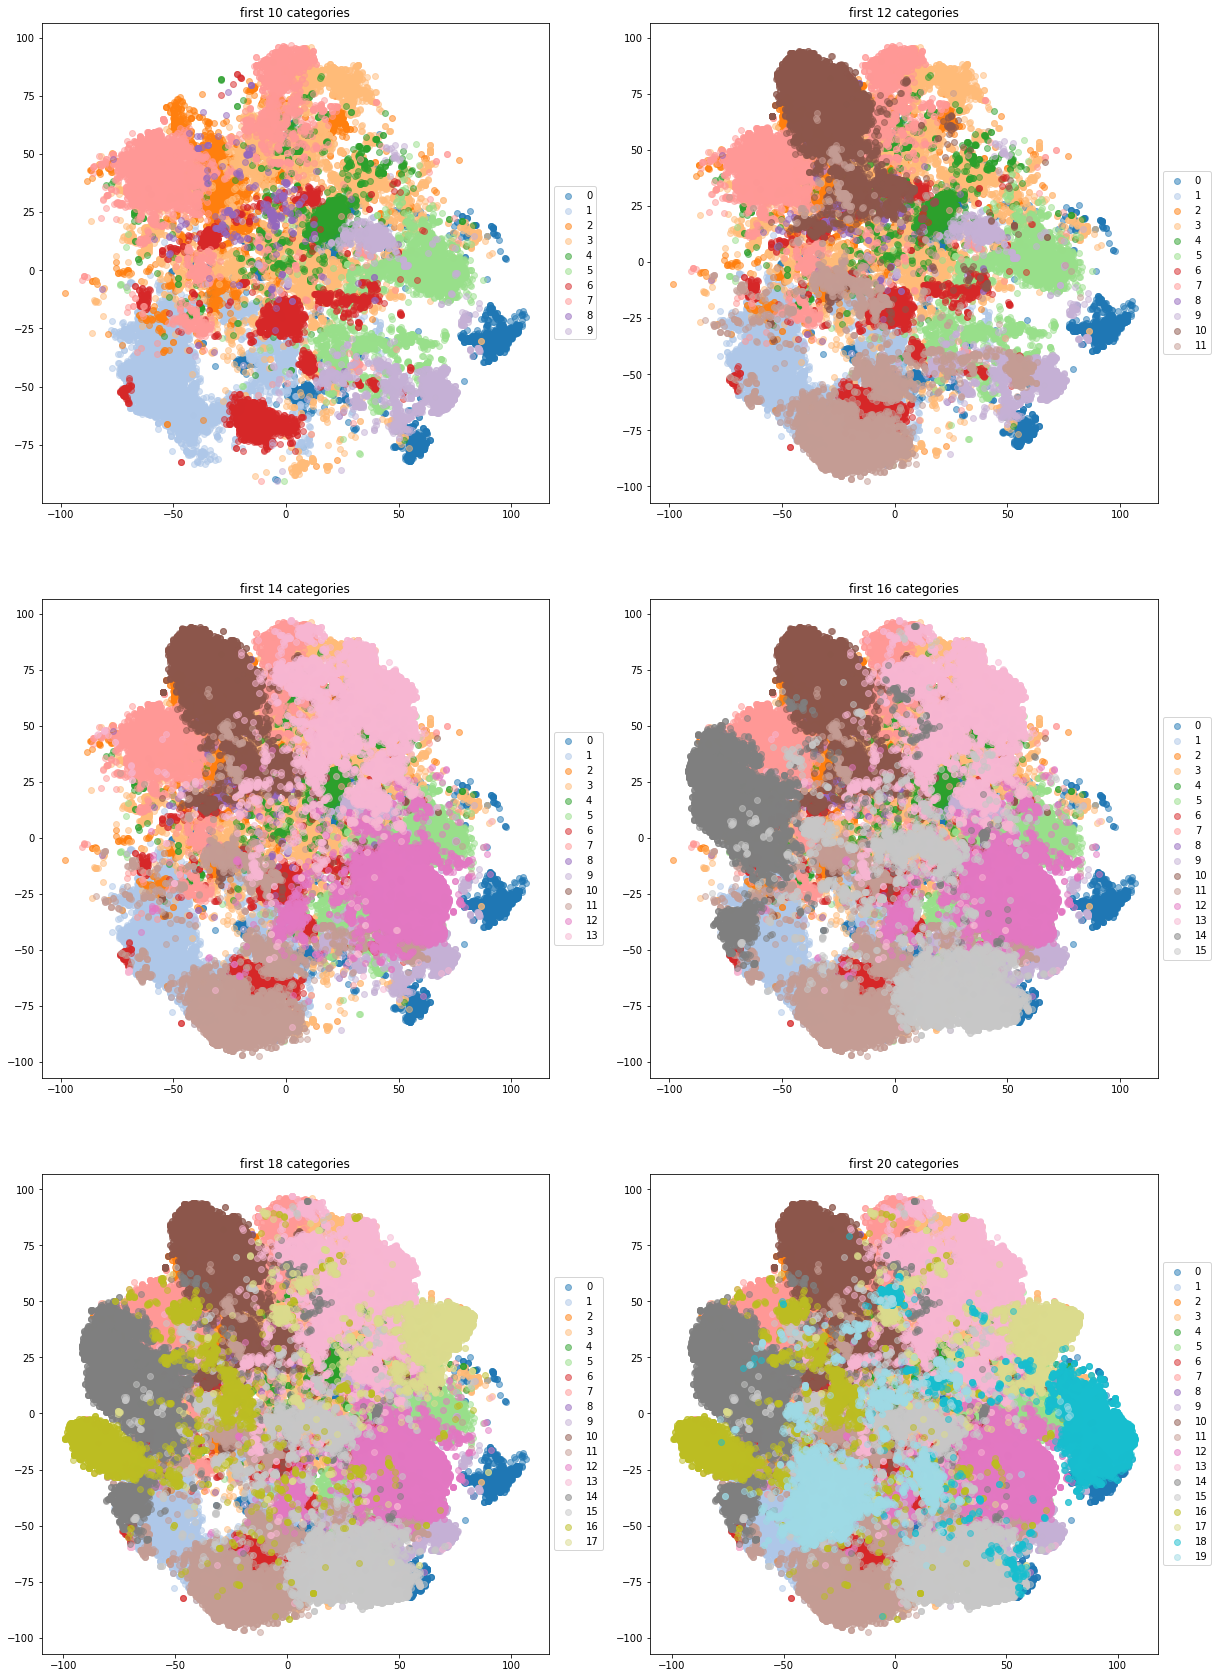

In [172]:
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(20,30))
for i,num_categories in enumerate(range(10,21,2)):
    for lab in range(num_categories):
        indices = test_predictions==lab
        ax[i//2][i%2].scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
        ax[i//2][i%2].set_title(f"first {num_categories} categories")
        ax[i//2][i%2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 134400 samples in 0.014s...
[t-SNE] Computed neighbors for 134400 samples in 345.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 134400
[t-SNE] Computed conditional probabilities for sample 2000 / 134400
[t-SNE] Computed conditional probabilities for sample 3000 / 134400
[t-SNE] Computed conditional probabilities for sample 4000 / 134400
[t-SNE] Computed conditional probabilities for sample 5000 / 134400
[t-SNE] Computed conditional probabilities for sample 6000 / 134400
[t-SNE] Computed conditional probabilities for sample 7000 / 134400
[t-SNE] Computed conditional probabilities for sample 8000 / 134400
[t-SNE] Computed conditional probabilities for sample 9000 / 134400
[t-SNE] Computed conditional probabilities for sample 10000 / 134400
[t-SNE] Computed conditional probabilities for sample 11000 / 134400
[t-SNE] Computed conditional probabilities for sample 12000 / 134400
[t-SNE] Computed conditional proba

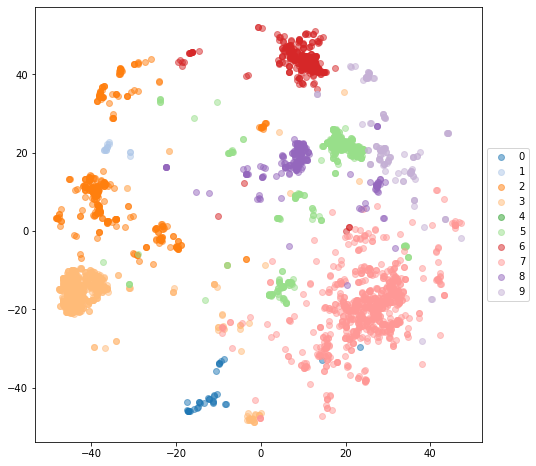

In [61]:

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [130]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0, 100, 101)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 165000 samples in 0.015s...
[t-SNE] Computed neighbors for 165000 samples in 502.386s...
[t-SNE] Computed conditional probabilities for sample 1000 / 165000
[t-SNE] Computed conditional probabilities for sample 2000 / 165000
[t-SNE] Computed conditional probabilities for sample 3000 / 165000
[t-SNE] Computed conditional probabilities for sample 4000 / 165000
[t-SNE] Computed conditional probabilities for sample 5000 / 165000
[t-SNE] Computed conditional probabilities for sample 6000 / 165000
[t-SNE] Computed conditional probabilities for sample 7000 / 165000
[t-SNE] Computed conditional probabilities for sample 8000 / 165000
[t-SNE] Computed conditional probabilities for sample 9000 / 165000
[t-SNE] Computed conditional probabilities for sample 10000 / 165000
[t-SNE] Computed conditional probabilities for sample 11000 / 165000
[t-SNE] Computed conditional probabilities for sample 12000 / 165000
[t-SNE] Computed conditional proba

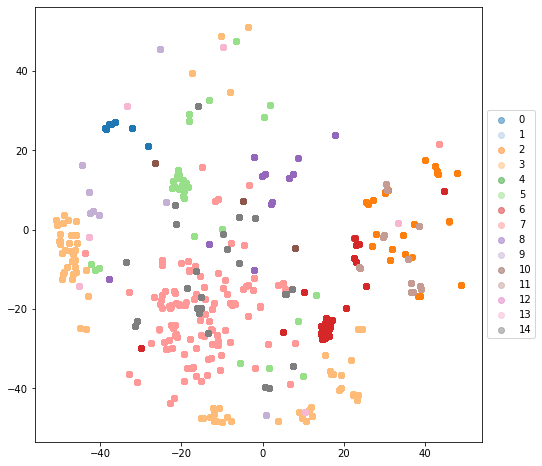

In [90]:
# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 15
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 134400 samples in 0.006s...
[t-SNE] Computed neighbors for 134400 samples in 345.228s...
[t-SNE] Computed conditional probabilities for sample 1000 / 134400
[t-SNE] Computed conditional probabilities for sample 2000 / 134400
[t-SNE] Computed conditional probabilities for sample 3000 / 134400
[t-SNE] Computed conditional probabilities for sample 4000 / 134400
[t-SNE] Computed conditional probabilities for sample 5000 / 134400
[t-SNE] Computed conditional probabilities for sample 6000 / 134400
[t-SNE] Computed conditional probabilities for sample 7000 / 134400
[t-SNE] Computed conditional probabilities for sample 8000 / 134400
[t-SNE] Computed conditional probabilities for sample 9000 / 134400
[t-SNE] Computed conditional probabilities for sample 10000 / 134400
[t-SNE] Computed conditional probabilities for sample 11000 / 134400
[t-SNE] Computed conditional probabilities for sample 12000 / 134400
[t-SNE] Computed conditional proba

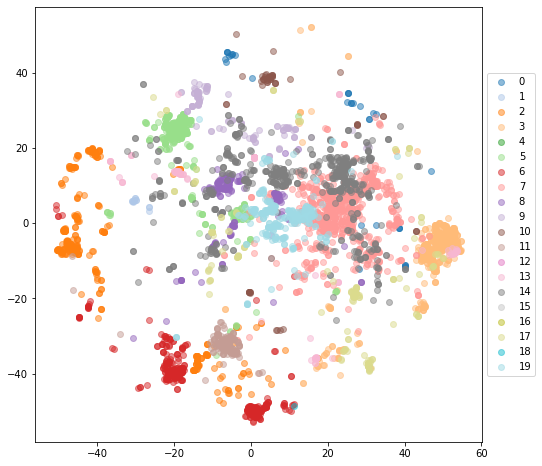

In [62]:

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 20
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [63]:

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 30
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 134400 samples in 0.013s...



KeyboardInterrupt



In [68]:
np.sum(indices)

366

In [69]:
for lab in range(num_categories):
    indices = test_predictions==lab
    print(lab,np.sum(indices))

0 34
1 13
2 358
3 923
4 0
5 545
6 429
7 799
8 210
9 121
10 63
11 201
12 0
13 141
14 633
15 0
16 0
17 163
18 1
19 366


In [176]:
# Create a two dimensional t-SNE projection of the embeddings
tsne_3 = TSNE(3, verbose=1,perplexity=50,learning_rate="auto")
tsne_proj_3 = tsne.fit_transform(test_embeddings)

/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 134400 samples in 0.013s...
[t-SNE] Computed neighbors for 134400 samples in 306.702s...
[t-SNE] Computed conditional probabilities for sample 1000 / 134400
[t-SNE] Computed conditional probabilities for sample 2000 / 134400
[t-SNE] Computed conditional probabilities for sample 3000 / 134400
[t-SNE] Computed conditional probabilities for sample 4000 / 134400
[t-SNE] Computed conditional probabilities for sample 5000 / 134400
[t-SNE] Computed conditional probabilities for sample 6000 / 134400
[t-SNE] Computed conditional probabilities for sample 7000 / 134400
[t-SNE] Computed conditional probabilities for sample 8000 / 134400
[t-SNE] Computed conditional probabilities for sample 9000 / 134400
[t-SNE] Computed conditional probabilities for sample 10000 / 134400
[t-SNE] Computed conditional probabilities for sample 11000 / 134400
[t-SNE] Computed conditional probabilities for sample 12000 / 134400
[t-SNE] Computed conditional prob

In [177]:
lwf.net

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals